**BUSINESS CONTEXT:** A Recognising multi-digit numbers in photographs captured at street level is an 
important component of modern-day map making. A classic example of a corpus of such street-level 
photographs is Google’s Street View imagery composed of hundreds of millions of geo-located 360-degree 
panoramic images. 
The ability to automatically transcribe an address number from a geo-located patch of pixels and associate the 
transcribed number with a known street address helps pinpoint, with a high degree of accuracy, the location of 
the building it represents. More broadly, recognising numbers in photographs is a problem of interest to the 
optical character recognition community. 
While OCR on constrained domains like document processing is well studied, arbitrary multi-character text 
recognition in photographs is still highly challenging. This difficulty arises due to the wide variability in the 
visual appearance of text in the wild on account of a large range of fonts, colours, styles, orientations, and 
character arrangements. 
The recognition problem is further complicated by environmental factors such as lighting, shadows, 
specularity, and occlusions as well as by image acquisition factors such as resolution, motion, and focus blurs. 
In this project, we will use the dataset with images centred around a single digit (many of the images do 
contain some distractors at the sides). Although we are taking a sample of the data which is simpler, it is more 
complex than MNIST because of the distractors.


**DATA DESCRIPTION:** The SVHN is a real-world image dataset for developing machine learning and object 
recognition algorithms with the minimal requirement on data formatting but comes from a significantly harder, 
unsolved, real-world problem (recognising digits and numbers in natural scene images). SVHN is obtained from 
house numbers in Google Street View images.
Where the labels for each of this image are the prominent number in that image i.e. 2,6,7 and 4 respectively.

Acknowledgement: Yuval Netzer, Tao Wang, Adam Coates, Alessandro Bissacco, Bo Wu, Andrew Y. Ng Reading 
Digits in Natural Images with Unsupervised Feature Learning NIPS Workshop on Deep Learning and 
Unsupervised Feature Learning 2011. 

**PROJECT OBJECTIVE:** Build a digit classifier on the SVHN (Street View Housing Number) dataset.

## 1. Import Library and Load Data

In [1]:
import pandas as pd
import numpy as np
import math
import time
import scipy.stats as stats
import h5py

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes = True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from sklearn import preprocessing

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, precision_recall_curve, auc
from sklearn.preprocessing import LabelEncoder

# Importing OpenCV module for the resizing function
import cv2

import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend

In [2]:
#Initialize the random number
import random
seed = 0
np.random.seed(seed)

#ignore worning
import warnings as wn
wn.filterwarnings("ignore")

### Load data from given h5 file

In [3]:
#load data
hf = h5py.File('Autonomous_Vehicles_SVHN_single_grey1.h5', "r")

In [4]:
#check the key from the dataset
hf.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

In [5]:
# Load the training, test and validation se
X_train = hf['X_train'][:]
y_train = hf['y_train'][:]
X_test = hf['X_test'][:]
y_test = hf['y_test'][:]
X_val = hf['X_val'][:]
y_val = hf['y_val'][:]

# Close this file
hf.close()

In [6]:
# Printing the shape and data type of training, testing, and validation data
print("X_train Shape :", X_train.shape,"and Data Type : ", X_train.dtype)
print("y_train Shape :", y_train.shape,"and Data Type : ", y_train.dtype)

print("X_test Shape  :", X_test.shape,"and Data Type : ", X_test.dtype)
print("y_test Shape  :", y_test.shape,"and Data Type : ", y_test.dtype)

print("X_val Shape   :", X_val.shape,"and Data Type : ", X_val.dtype)
print("y_val Shape   :", y_val.shape,"and Data Type : ", y_val.dtype)

X_train Shape : (42000, 32, 32) and Data Type :  float32
y_train Shape : (42000,) and Data Type :  uint8
X_test Shape  : (18000, 32, 32) and Data Type :  float32
y_test Shape  : (18000,) and Data Type :  uint8
X_val Shape   : (60000, 32, 32) and Data Type :  float32
y_val Shape   : (60000,) and Data Type :  uint8


## 2. Data pre-processing and visualisation

6   7   4   4   0   3   0   7   3   1   
0   1   3   1   1   0   0   8   4   6   
5   7   9   1   0   3   0   7   2   1   
1   0   2   9   0   2   5   1   3   2   
7   9   8   4   9   4   5   9   3   4   
0   5   5   8   3   6   6   0   0   6   
8   8   3   1   4   7   0   2   9   4   
8   7   3   9   4   4   3   3   4   4   
8   6   8   7   4   0   4   4   4   1   
4   2   7   4   2   9   1   9   1   0   


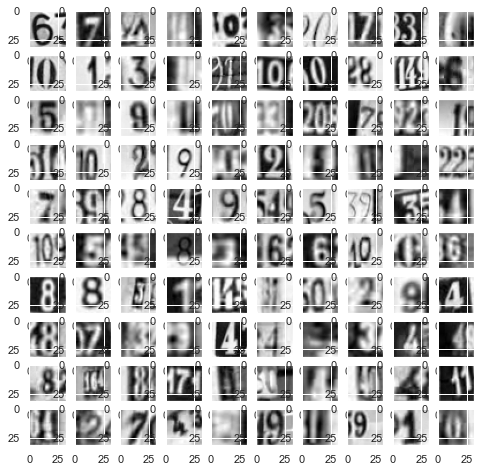

In [7]:
#visualize 10 rows and columns data
columns=10
rows=10

#fig size
fig=plt.figure(figsize=(8, 8))

#iterate data
for i in range(1, columns*rows+1):
    img = X_train[i]
    fig.add_subplot(rows, columns, i)
    print(y_train[i], end='   ')
    
    if i % columns == 0:
        print ("")
    plt.imshow(img, cmap='gray')

plt.show()

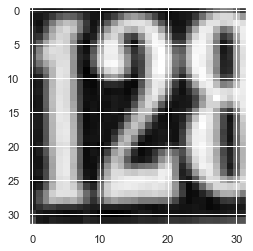

Label:  2


In [8]:
# show the number in the dataset
plt.imshow(X_train[0], cmap='gray')    
plt.show()
print('Label: ', y_train[0])

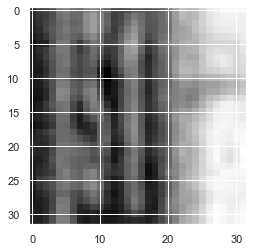

Label:  1


In [9]:
# show the number in the dataset
plt.imshow(X_test[0],cmap='gray')    
plt.show()
print('Label: ', y_test[0])

## 3. Design, train, tune and test a neural network image classifier

### Implementing Deep Neural Network

In [10]:
#Reshape data from 2D to 1D -> 32X32 to 1024
X_train = np.asarray(X_train).reshape((X_train.shape[0], -1))
X_test = np.asarray(X_test).reshape((X_test.shape[0], -1))
X_val = np.asarray(X_val).reshape((X_val.shape[0], -1))

# X_train = X_train.reshape((X_train.shape[0], -1))
# X_test = X_test.reshape((X_test.shape[0], -1))
# X_val = X_val.reshape((X_val.shape[0], -1))

In [11]:
#Normalize the data from 0-255 to 0-1 by dividing the inputs by 255. 
#The denominator should be a float, else the output would become 0. 
X_train = X_train / 255.0 
X_val = X_val / 255.0

#### Converting output label to multiple values

In [12]:
#the out put is 10 class problem
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)                                       

In [13]:
#pring the converted value
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(42000, 1024) (18000, 1024) (60000, 1024) (42000, 10) (18000, 10) (60000, 10)


### Implementing Neural Network

In [14]:
class LearningRateRecoder(Callback):
    def on_train_begin(self, logs={}):
        self.lrates = list()
        
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        lrate = float(backend.get_value(optimizer.lr))
        self.lrates.append(lrate)

In [15]:
##This class use to build a sigle layer acrchitecture
class NaiveModel:
    def __init__(self, lr, BatchSize = 128):
        self.model = Sequential()
        self.lr = lr
        self.BatchSize = BatchSize  ##This is for mini-batch gradient descent batch size
        
    #Function for compiling the model
    def __ComplileWithSGD(self, optimizer, momentum = 0.66):
        if(optimizer =="ADAM"):
            opt = Adam(lr=self.lr)
        elif(optimizer =="RMSPROP"):
            opt = RMSprop(lr = self.lr)
        else:
            opt = SGD(lr = self.lr, momentum=momentum)
            
        #compile model
        self.model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
        self.optimizer = optimizer
        
        #print(self.model.summary())
        plot_model(self.model, show_shapes=True, to_file='naivemodel.png')
        
    #define sequencial Model
    def BuildSequentialWithoutBatchNorm(self, noofClasses, optimizer):
        self.model.add(Dense(512, activation='relu', kernel_initializer = 'he_uniform', input_shape=(1024, )))
        self.model.add(Dense(256, activation='relu', kernel_initializer = 'he_uniform'))
        self.model.add(Dense(128, activation='relu', kernel_initializer = 'he_uniform'))
        self.model.add(Dense(64, activation='relu', kernel_initializer = 'he_uniform'))
        self.model.add(Dense(32, activation='relu', kernel_initializer = 'he_uniform'))
        self.model.add(Dense(noofClasses, activation='softmax'))
        self.__ComplileWithSGD(optimizer)
        
    def BuildSequentialWithBatchNorm(self, noofClasses, optimizer):
        self.model.add(Dense(512, kernel_initializer='he_normal',input_shape = (1024, )))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        
        self.model.add(Dense(256, kernel_initializer='he_normal'))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        
        self.model.add(Dense(128, kernel_initializer='he_normal'))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        
        self.model.add(Dense(64, kernel_initializer='he_normal'))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        
        self.model.add(Dense(32, kernel_initializer='he_normal'))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        
        self.model.add(Dense(noofClasses, activation='softmax'))
        self.__ComplileWithSGD(optimizer)
        
    #fit fucniton for nerural network to train model
    # When we do model the fit, it call the gradient descent with training data x, target y and the no.of epochs mentioned
    def Fit(self, patience, trainX, trainY, testX, testY, verbose_out, noOfEpochs=100):
        onplateau = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = patience, min_delta= 1E-6)
        lr_recorder = LearningRateRecoder()
        
        # simple early stopping
        #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        self.history = self.model.fit(trainX, trainY, 
                                      validation_data=(testX, testY),
                                      epochs = noOfEpochs, 
                                      verbose= verbose_out, 
                                      batch_size = self.BatchSize,
                                     callbacks = [onplateau, lr_recorder])
        
        self.actullr = lr_recorder.lrates
        self.patience = patience
        _, self.test_accuracy = self.model.evaluate(testX, testY, verbose=verbose_out)
        self.test_accuracy = round(self.test_accuracy, 3)
        return self.model
    
    
    ##Ploting the metics info
    ##Ploting the metics info
    def PlotFit(self):
        h1 = self.history.history
        ##print(h1)
        
        #fig size
        plt.figure(figsize=(20, 6))
        
        #Epochs Vs Train Accuracy
        plt.subplot(1, 3, 1)
        ax = sns.lineplot(y = h1['val_accuracy'], x = range(len(h1['val_accuracy'])), label = "val_acc", palette='binary')
        ax.set(xlabel='ephochs', ylabel='val_accuracy')
        ax = sns.lineplot(y = h1['accuracy'], x =  range(len(h1['val_accuracy'])), label = "accuracy", palette='flare')
        ax.set(xlabel='ephochs', ylabel='Accuracy')
        plt.title('Epochs Vs Train Accuracy (Acc ='+str(self.test_accuracy)+')')
        
        #Validate Vs Train Accuracy
        plt.subplot(1, 3, 2)
        ax = sns.lineplot(x = h1['accuracy'], y =  h1['val_accuracy'], label = "acc vs val_acc", palette='binary', color='green', sort=False)
        ax.set(xlabel='accuracy', ylabel='val accuaracy')
        plt.legend()
        plt.title('Validate Vs Train Accuracy (Acc ='+str(self.test_accuracy)+')')
        
        #Loss plot
        plt.subplot(1, 3, 3)
        pdtmp1 = abs(pd.DataFrame(h1['loss']) - pd.DataFrame(h1['val_loss']))
        pdtmp1.fillna(0, inplace=True)
        ax = sns.lineplot(y = pdtmp1[0], x = range(0, len(h1['val_loss']), 1), label = "Loss Convergence", color='red')
        ax.set(xlabel='ephochs', ylabel='abs(val loss - loss)')
        plt.legend()
        plt.title('Loss (Acc ='+str(self.test_accuracy)+')')
        plt.show()
        
###Utility function to create NaiveModel, fit and plot
def BuildSequentialWithoutBatchNormFactory(noofClusters, optimizer, lr, patience, trainX, trainy, testX, testy, verbose_out):
    model1 = NaiveModel(lr)
    model1.BuildSequentialWithoutBatchNorm(noofClusters, optimizer)
    model1.Fit(patience, trainX, trainy, testX, testy, verbose_out)
    model1.PlotFit()
    
def BuildSequentialWithBatchNormFactory(noofClusters, optimizer, lr, patience, trainX, trainy, testX, testy, verbose_out):
    model1 = NaiveModel(lr)
    model1.BuildSequentialWithBatchNorm(noofClusters, optimizer)
    model = model1.Fit(patience, trainX, trainy, testX, testy, verbose_out)
    model1.PlotFit()
    return model

In [16]:
def PrintSensitivityAnalysis(optimizer, norm):
    lr_start = [0.01, 0.001, 0.0001]
    patience_arr = [5]
    noOfClusters = 10
    
    print(optimizer)
    for i in range(len(lr_start)):
        for j in range(len(patience_arr)):
            if( norm == 0):
                BuildSequentialWithoutBatchNormFactory(noOfClusters, 
                                                       optimizer, 
                                                       lr_start[i], 
                                                       patience_arr[j], 
                                                       X_train, 
                                                       y_train, 
                                                       X_val, 
                                                       y_val,
                                                       0)
            else:
                BuildSequentialWithBatchNormFactory(noOfClusters, 
                                                   optimizer, 
                                                   lr_start[i], 
                                                   patience_arr[j], 
                                                   X_train, 
                                                   y_train, 
                                                   X_val, 
                                                   y_val,
                                                   0)

SGD


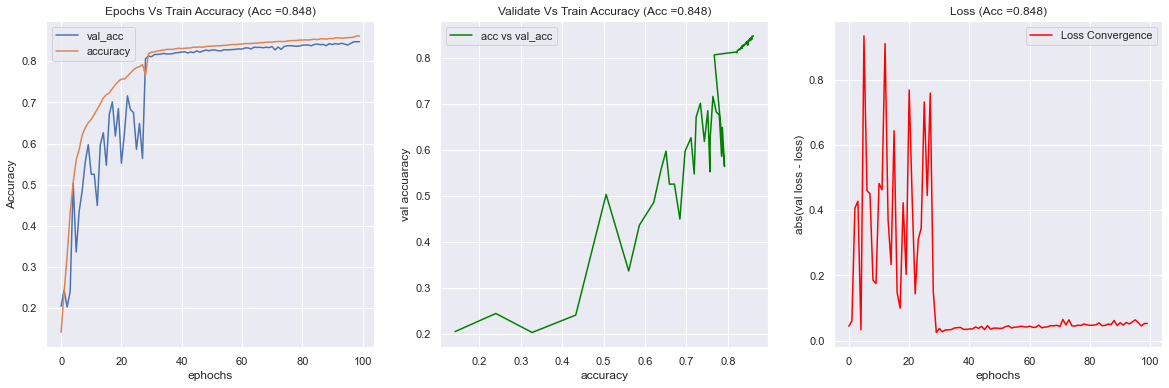

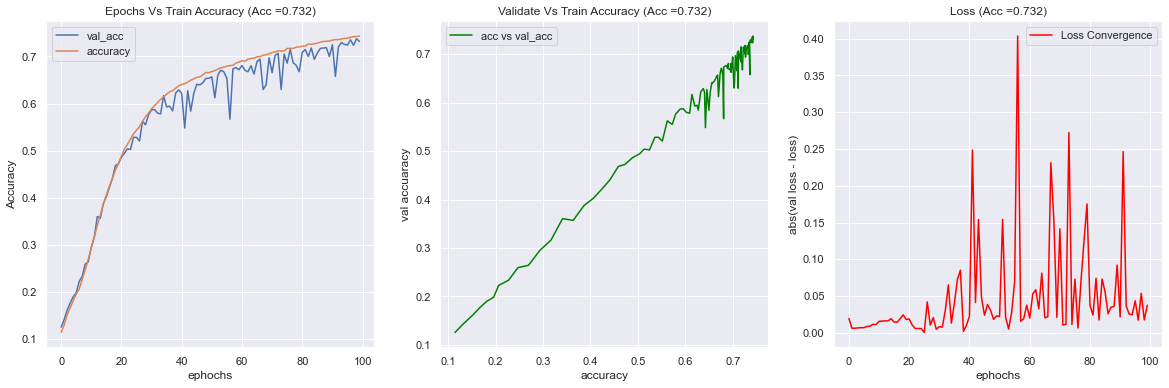

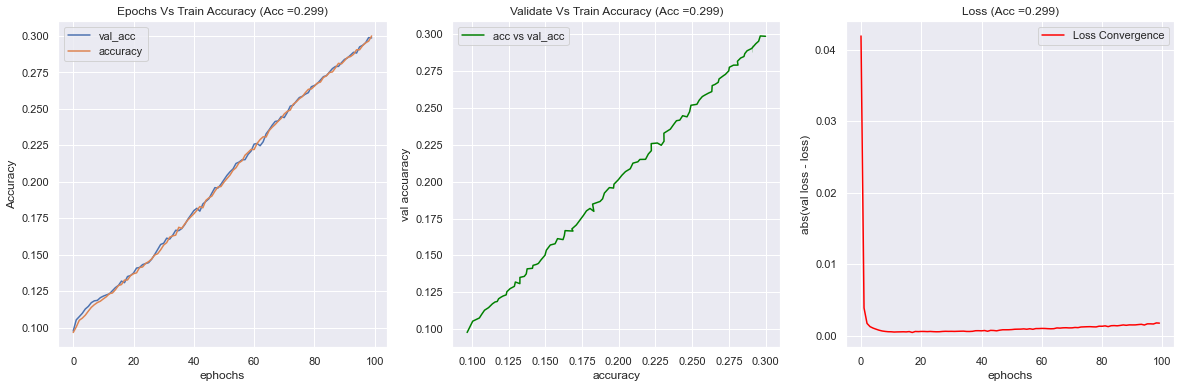

In [17]:
#BuildSequentialWithoutBatchNormFactory
#Model with learning rate [0.01, 0.001, 0.0001] without batch normalization.
PrintSensitivityAnalysis("SGD", 0)

ADAM


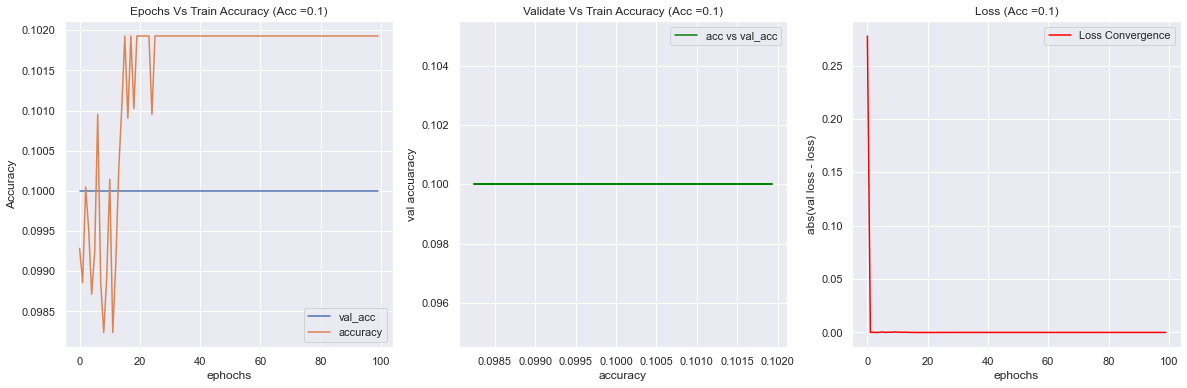

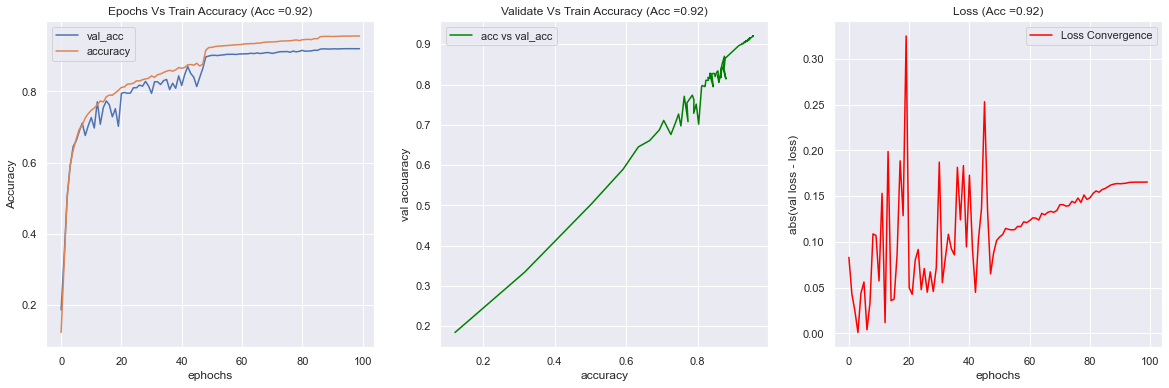

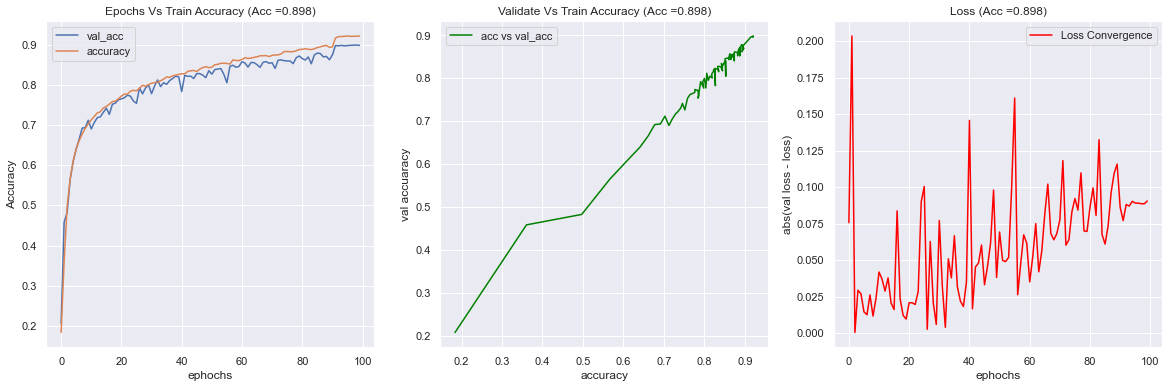

In [18]:
#BuildSequentialWithoutBatchNormFactory
#Model with learning rate [0.01, 0.001, 0.0001] without batch normalization.
PrintSensitivityAnalysis("ADAM", 0)  

RMSPROP


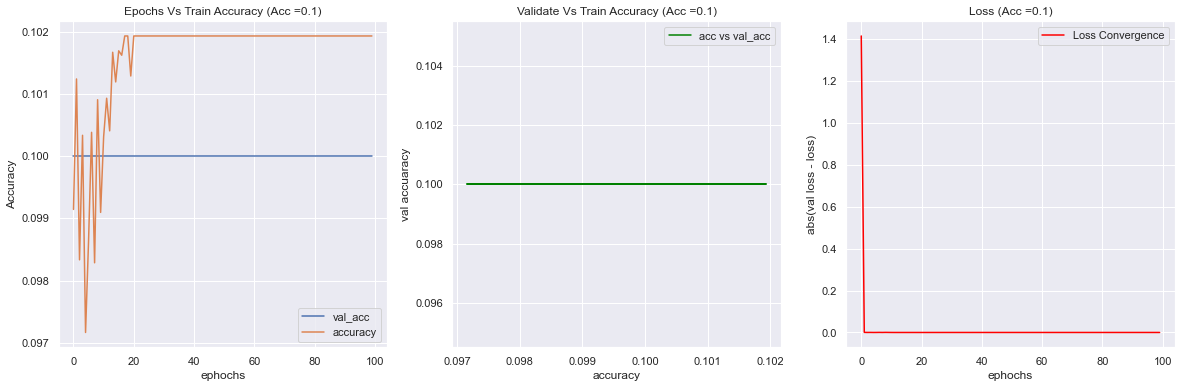

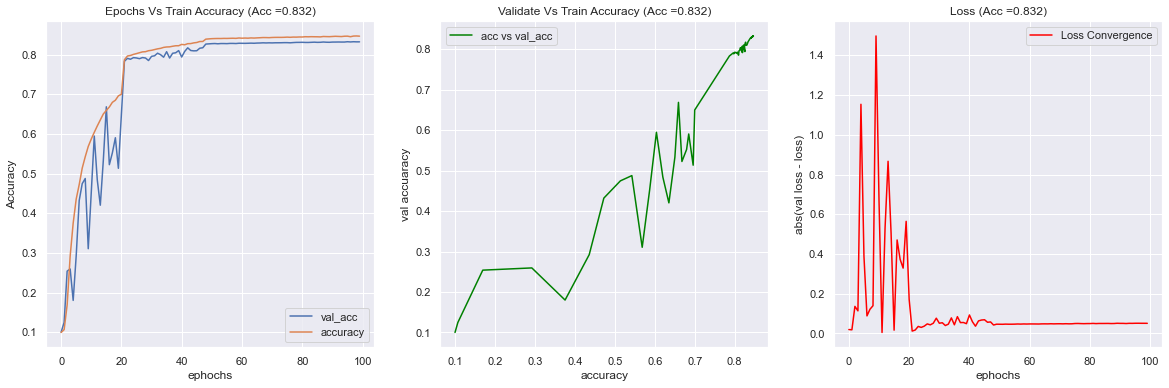

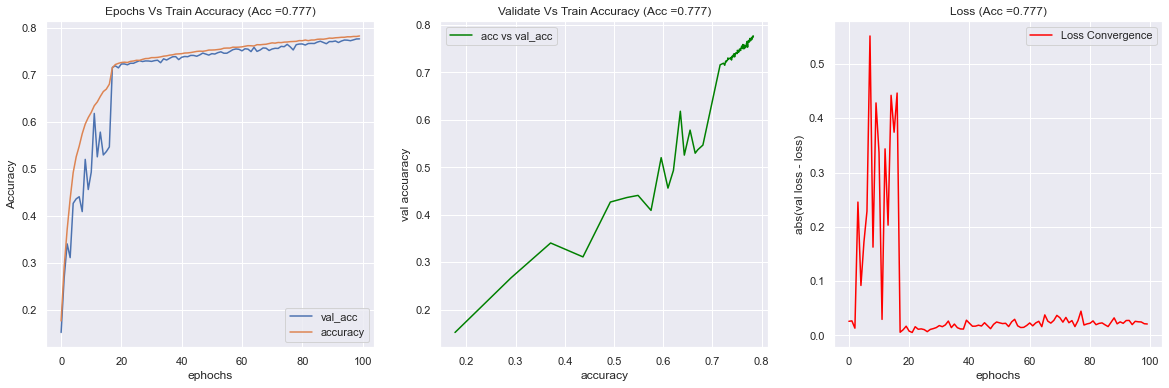

In [19]:
#BuildSequentialWithoutBatchNormFactory
#Model with learning rate [0.01, 0.001, 0.0001] without batch normalization.
PrintSensitivityAnalysis("RMSPROP", 0)

SGD


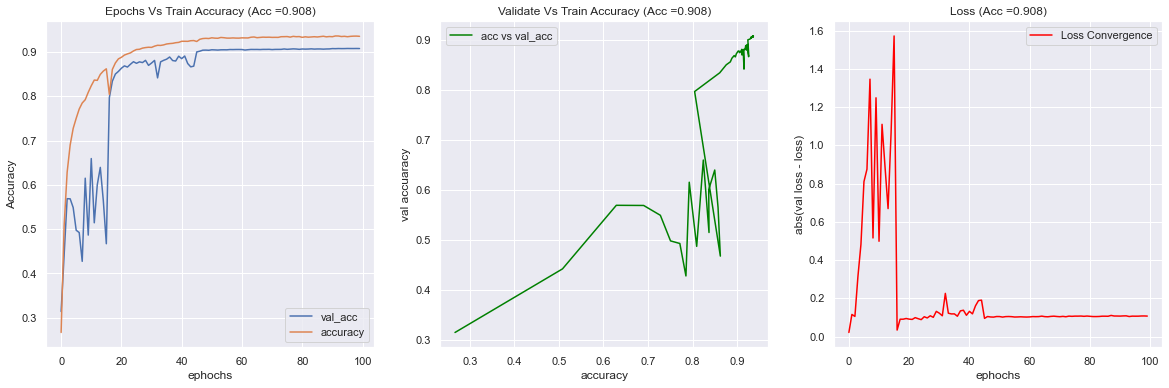

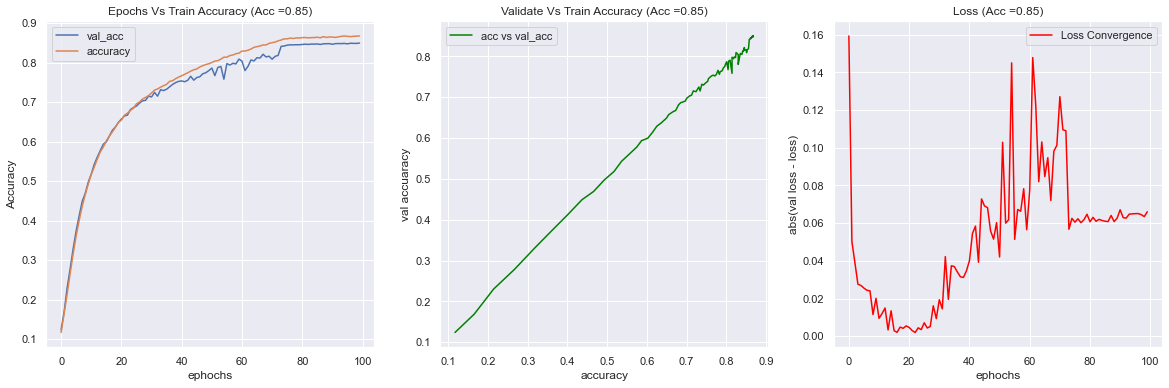

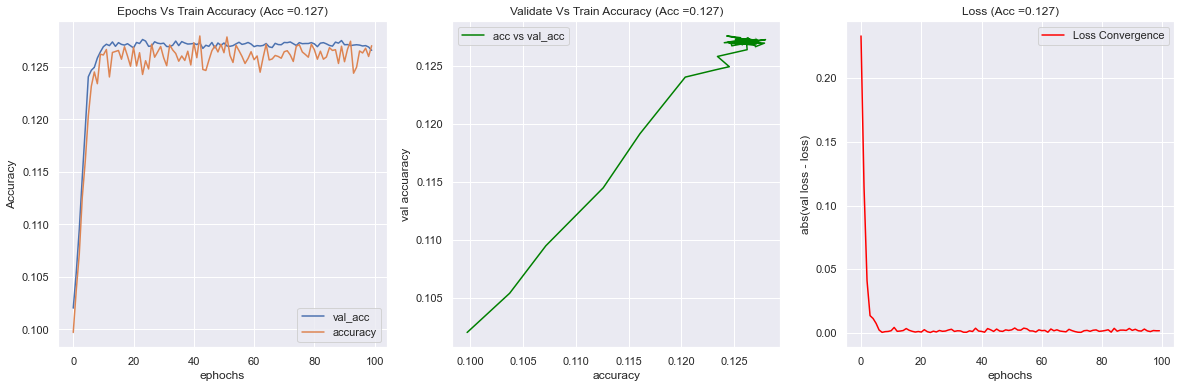

In [20]:
#BuildSequentialWithBatchNormFactory
#Model with learning rate [0.01, 0.001, 0.0001] with batch normalization.
PrintSensitivityAnalysis("SGD", 1)

ADAM


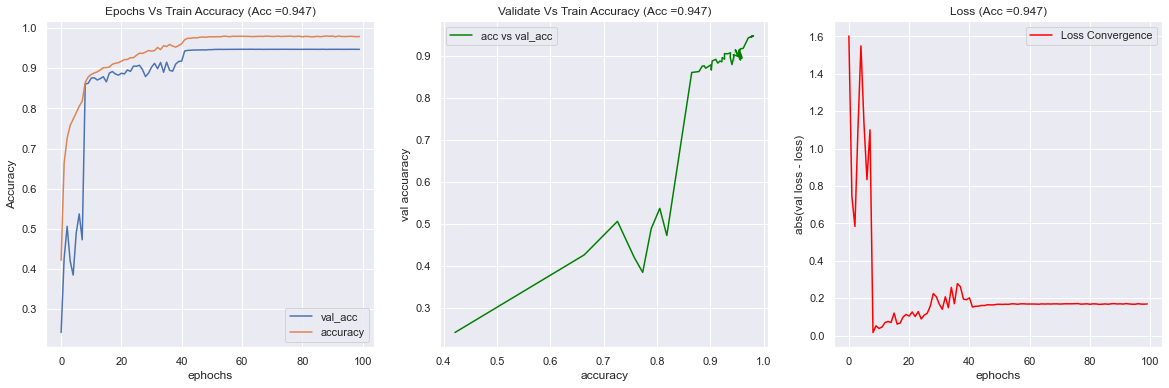

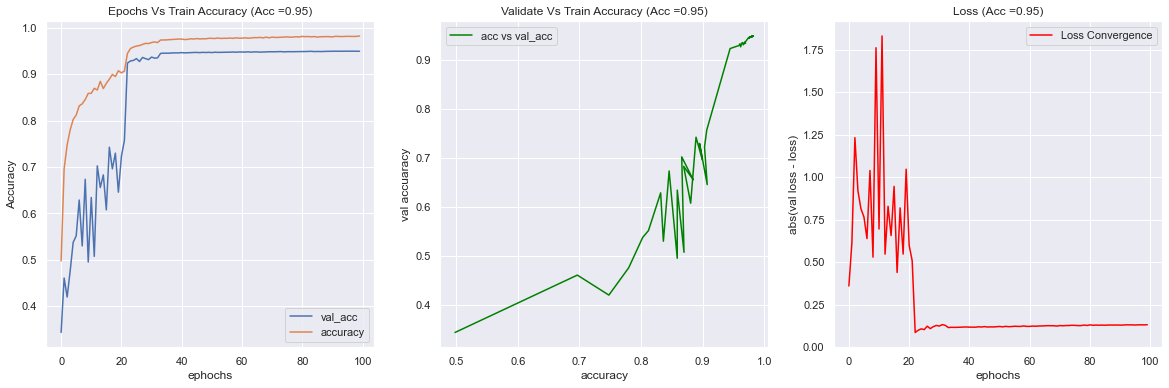

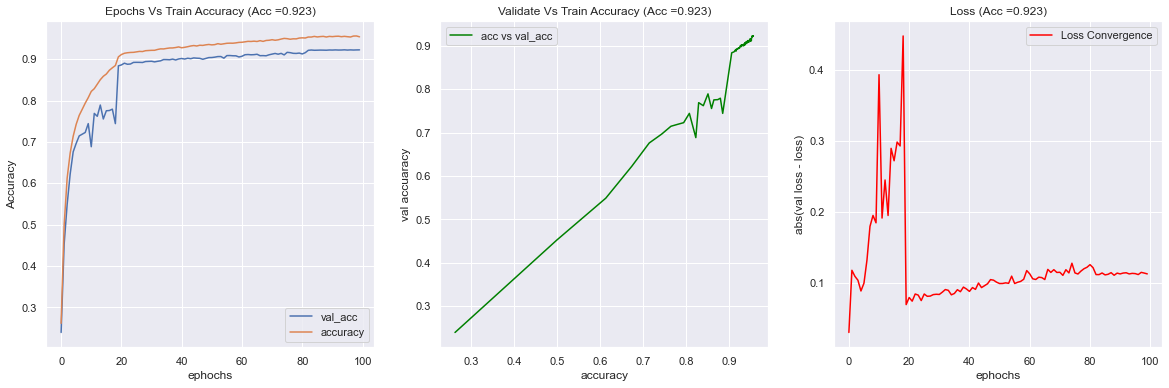

In [21]:
#BuildSequentialWithBatchNormFactory
#Model with learning rate [0.01, 0.001, 0.0001] with batch normalization.
PrintSensitivityAnalysis("ADAM", 1)  

RMSPROP


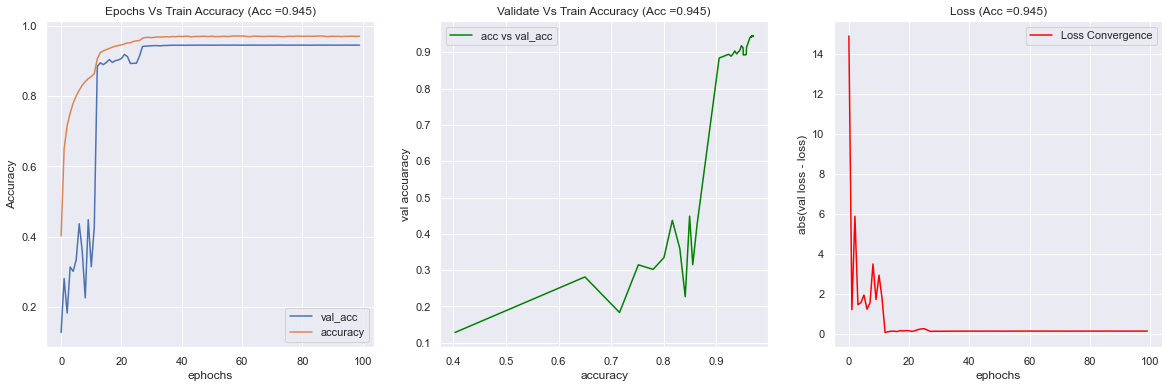

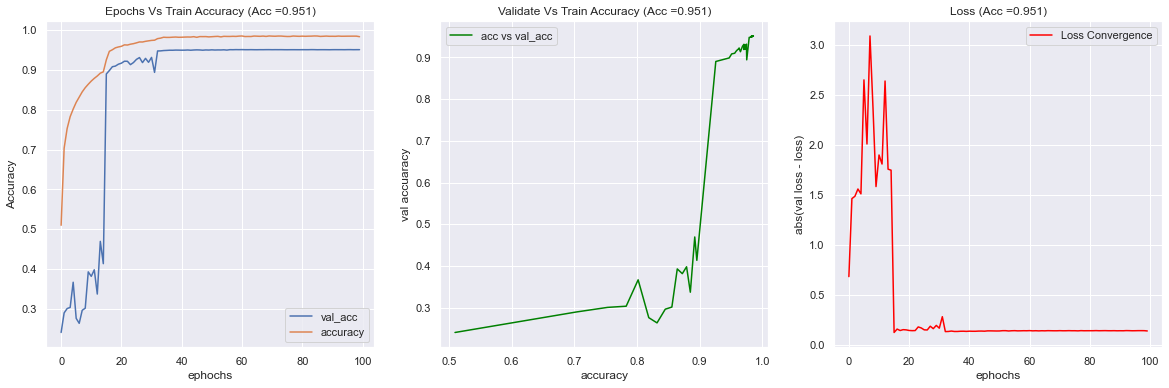

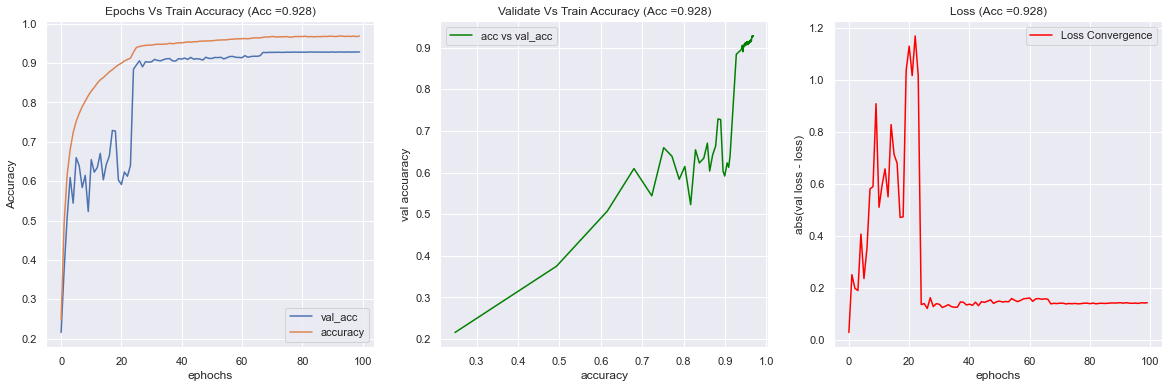

In [22]:
#BuildSequentialWithBatchNormFactory
#Model with learning rate [0.01, 0.001, 0.0001] with batch normalization.
PrintSensitivityAnalysis("RMSPROP", 1)

### From above graph validation with different optimisor and learning rate, it observed that:
   - **Adam with leaning rate 0.01 and with BatchNormalization the model looks more stable after 40 ecpochs accuracy nearly 95%. But the error little volatile till 40 epochs.**
   - **RMSPROP with learning rate 0.01 and with BatchNormalization the model looks more stable after 25 ecpochs accuracy nearly 95%. But the error leass after 10 epochs.**

### Using RMSPROP

Epoch 1/100
329/329 [==============================] - 7s 17ms/step - loss: 1.5670 - accuracy: 0.4533 - val_loss: 7.2683 - val_accuracy: 0.1917
Epoch 2/100
329/329 [==============================] - 5s 16ms/step - loss: 1.0193 - accuracy: 0.6716 - val_loss: 2.5617 - val_accuracy: 0.3204
Epoch 3/100
329/329 [==============================] - 6s 17ms/step - loss: 0.8469 - accuracy: 0.7300 - val_loss: 2.7784 - val_accuracy: 0.3272
Epoch 4/100
329/329 [==============================] - 5s 16ms/step - loss: 0.7446 - accuracy: 0.7627 - val_loss: 1.6353 - val_accuracy: 0.4668
Epoch 5/100
329/329 [==============================] - 5s 16ms/step - loss: 0.6694 - accuracy: 0.7889 - val_loss: 1.7573 - val_accuracy: 0.4746
Epoch 6/100
329/329 [==============================] - 6s 18ms/step - loss: 0.6145 - accuracy: 0.8050 - val_loss: 1.4015 - val_accuracy: 0.5353
Epoch 7/100
329/329 [==============================] - 5s 16ms/step - loss: 0.5688 - accuracy: 0.8191 - val_loss: 2.8582 - val_accuracy:

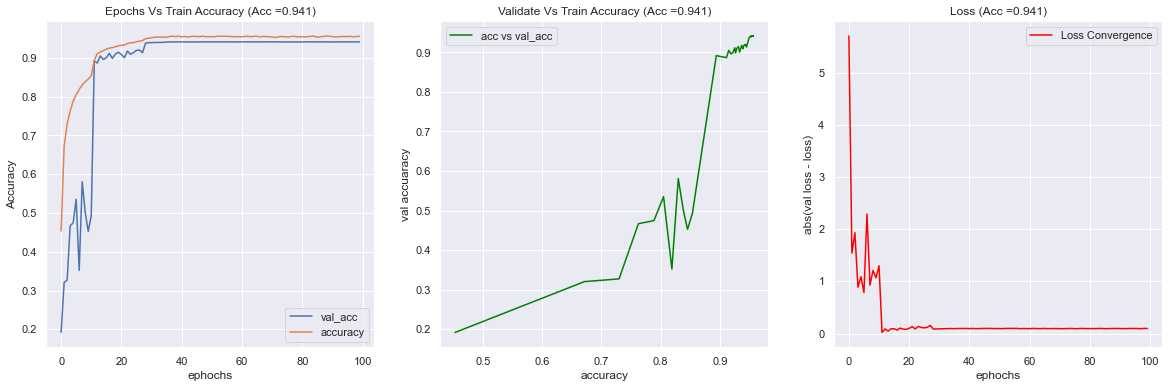

In [17]:
## RMSPROP with learning rate 0.01, batch size 128 and 100 epochs
kera_model = BuildSequentialWithBatchNormFactory(10, 
                                    "RMSPROP", 
                                    0.01, 
                                    5, 
                                    X_train, 
                                    y_train, 
                                    X_val, 
                                    y_val,
                                   1)

- **As we obserbed with RMSPROP optimizer and using BatchNorm after 40 epoch the model reached 94% accuracy and loss initially little volatile but after 25 ephoch the loss is stream line below 0.2.**
- **Validation and train accuracy nealry same**

In [19]:
#Normalize test data
X_test = X_test / 255.0

In [20]:
#Test accuracy
kera_model.evaluate(X_test, y_test)

563/563 [==============================] - 2s 3ms/step - loss: 0.5844 - accuracy: 0.8647


[0.5843563079833984, 0.8646666407585144]

- **As we observed test accuracy is nearly 87%. Compartively low compare to validation accuracy**.

### Using Adam

Epoch 1/100
329/329 [==============================] - 6s 13ms/step - loss: 1.6885 - accuracy: 0.3896 - val_loss: 2.1718 - val_accuracy: 0.3018
Epoch 2/100
329/329 [==============================] - 4s 12ms/step - loss: 1.0601 - accuracy: 0.6547 - val_loss: 2.0377 - val_accuracy: 0.3751
Epoch 3/100
329/329 [==============================] - 4s 13ms/step - loss: 0.8839 - accuracy: 0.7188 - val_loss: 1.7610 - val_accuracy: 0.5053
Epoch 4/100
329/329 [==============================] - 4s 12ms/step - loss: 0.7643 - accuracy: 0.7592 - val_loss: 1.1413 - val_accuracy: 0.6205
Epoch 5/100
329/329 [==============================] - 4s 13ms/step - loss: 0.6954 - accuracy: 0.7813 - val_loss: 1.6177 - val_accuracy: 0.5318
Epoch 6/100
329/329 [==============================] - 4s 12ms/step - loss: 0.6323 - accuracy: 0.8011 - val_loss: 1.3476 - val_accuracy: 0.5855
Epoch 7/100
329/329 [==============================] - 5s 15ms/step - loss: 0.5993 - accuracy: 0.8107 - val_loss: 0.9173 - val_accuracy:

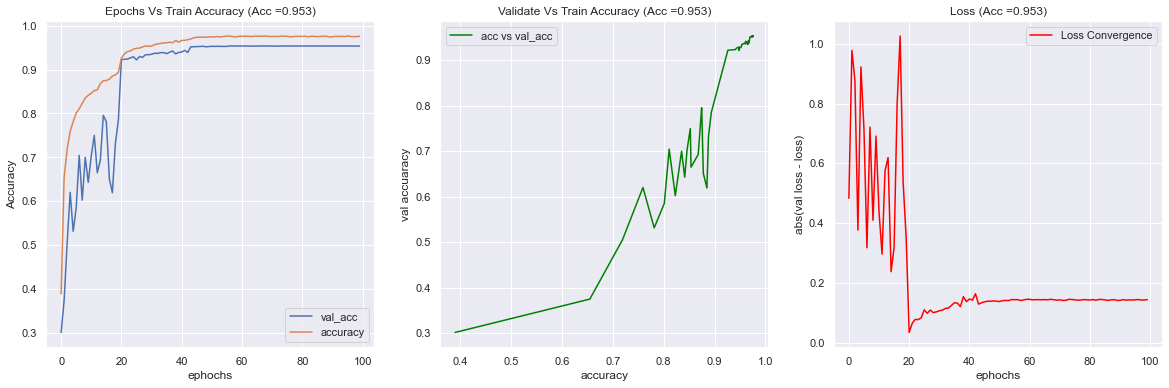

In [21]:
## Adam with learning rate 0.01, batch size 128 and 100 epochs
kera_model1 = BuildSequentialWithBatchNormFactory(10, 
                                    "ADAM", 
                                    0.01, 
                                    5, 
                                    X_train, 
                                    y_train, 
                                    X_val, 
                                    y_val,
                                   1)

In [22]:
#Test accuracy
kera_model1.evaluate(X_test, y_test)

563/563 [==============================] - 2s 3ms/step - loss: 0.6584 - accuracy: 0.8647


[0.6584138870239258, 0.8647222518920898]

- **Using Adam with learning rate 0.01,  the traina and validation score is nearly 95% and test score 87%.**

### Predicting the digits using NN classifier on test data using RMSPROP

Predicted label: 9


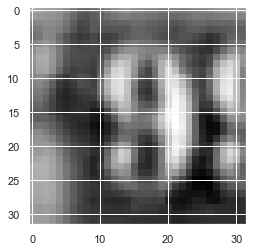

In [50]:
#Showing the image
plt.imshow(X_test[5].reshape(32,32),cmap='gray')

#Predicting the digits
print('Predicted label:',kera_model.predict_classes(X_test)[5])

In [46]:
#Predicting the digits
kera_model.predict_classes(X_test)[5]

9

#### Image 2

Predicted label: 2


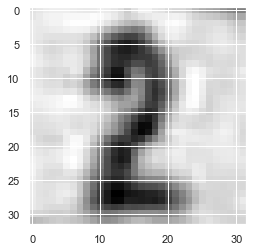

In [54]:
#Showing the image
plt.imshow(X_test[2].reshape(32,32),cmap='gray')

#Predicting the digits
print('Predicted label:',kera_model.predict_classes(X_test)[2])

In [53]:
#Predicting for all images
y_pred=kera_model.predict_classes(X_test)
print(y_pred)

[9 7 2 ... 7 9 2]


### Observations:

- **From different learning rate and optimizer it observed that the data set givning best accuracy of nearly 95% using "Adam" and "RMSPROP" optimizer with learning rate 0.01 and batch size 128.**
- **Also it obserd the test score is less compare to traina and validation score. So need more experiment.**
- **What i observed can be more experimental with diffent no.of neurons and batchsize. The limitation i faces the running time of the code. Both colab and local it took half day to run the code once.**